**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
# Import everything needed to edit/save/watch video clips
from IPython.display import HTML

%matplotlib inline

### Camera Calibration

#### Find chessboard corners

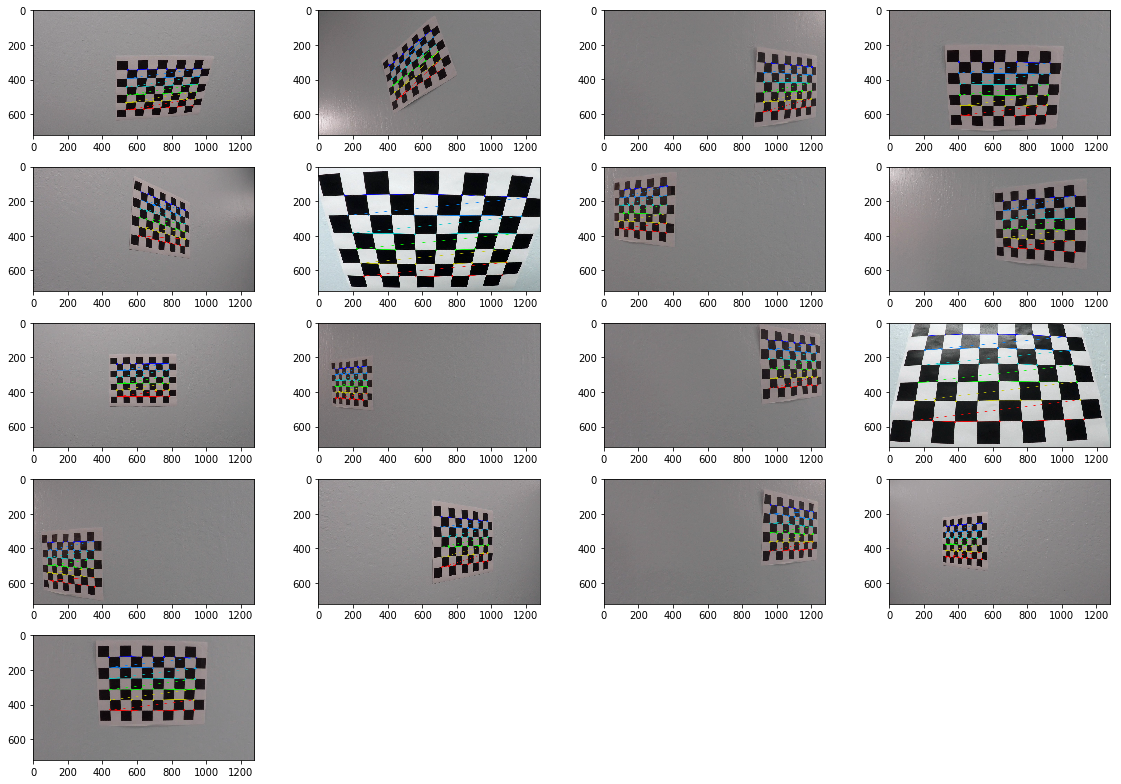

In [2]:
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

objp = np.zeros((nx*ny, 3), np.float32) 
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x and y cordinates.
objpoints = []
imgpoints = []

folder = "camera_cal/"

plt.figure(1, figsize=(16, 11))

ind = 0
for fname in os.listdir("camera_cal/"):
    img = cv2.imread(folder+fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        plt.subplot(5, 4, ind+1)
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        ind += 1
# plt.show()

plt.tight_layout()

plt.savefig('output_images/' + 'chessboardEdges.png')

#### Apply image undistortion to chessboard images

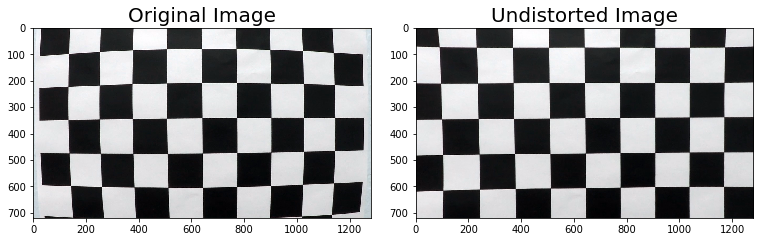

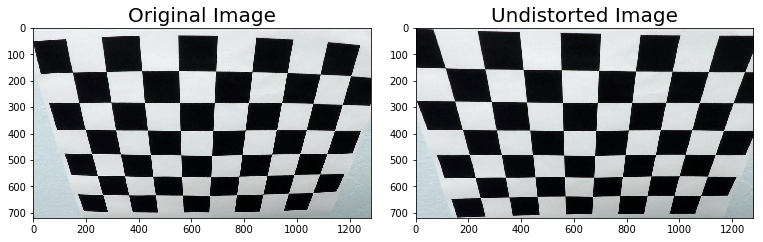

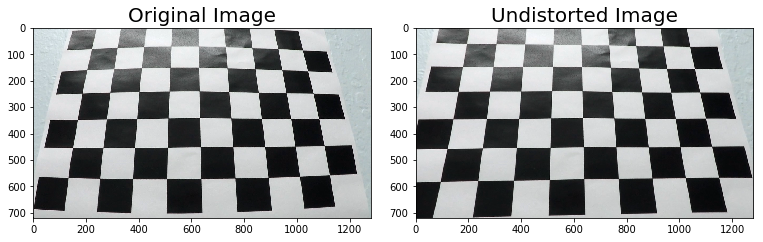

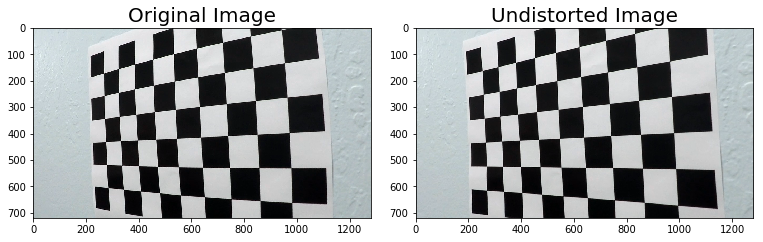

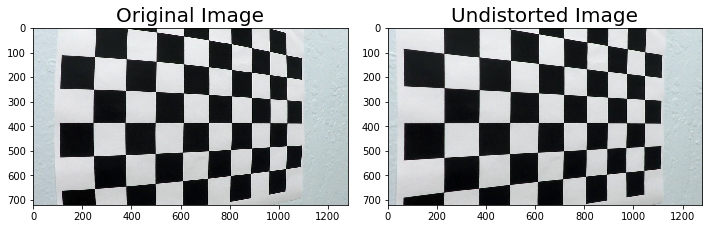

In [3]:
# Read in an image
folder = "camera_cal/"

imageNames = ['calibration1.jpg', 'calibration2.jpg', 'calibration3.jpg', 'calibration4.jpg', 'calibration5.jpg']

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    orig_img = np.copy(img)  # Delete this line
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(orig_img, mtx, dist, None, mtx)
    return undist

for fname in imageNames:

#     fname = folder + 'calibration2.jpg'
    img = cv2.imread(folder+fname)

    undistorted = cal_undistort(img, objpoints, imgpoints)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     plt.show()

plt.tight_layout()

plt.savefig('output_images/' + 'chessboardUndistored.png')

#### Apply image undistortion to vehicle camera image

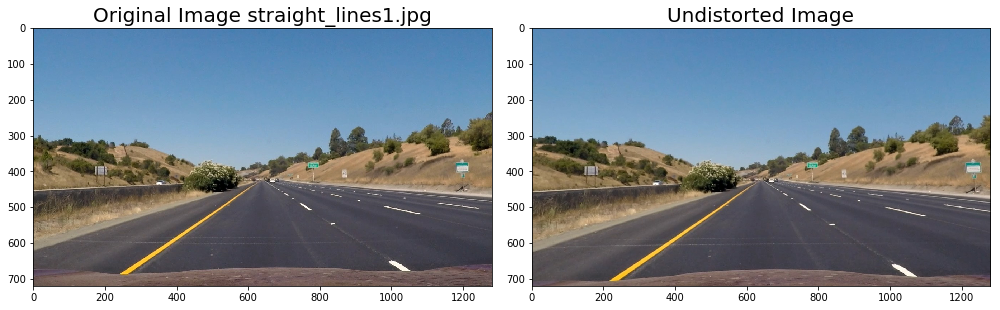

In [4]:
folder = 'test_images/'

fname = 'straight_lines1.jpg'

img = cv2.imread(folder+fname)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image '+fname, fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.tight_layout()

plt.savefig('output_images/' + 'cameraUndistorted.png')

### Perspective transform

Apply perspective transform to one test camera image

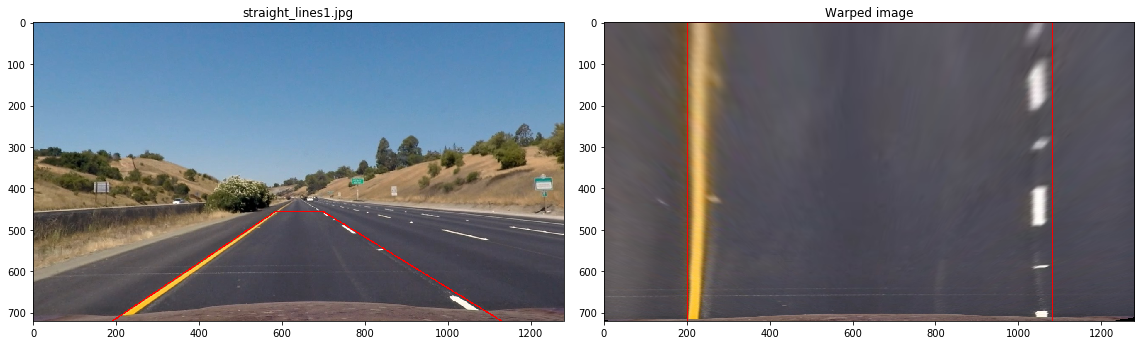

In [5]:
copy = undistorted.copy()

size_x = undistorted.shape[1]
size_y = undistorted.shape[0]

bottomY = size_y
topY = 455

## Source points
src_left1 = [190, bottomY]
src_left2 = [585, topY]
src_right1 = [698, topY]
src_right2 = [1130, bottomY]

color = [255, 0, 0]
w = 2
cv2.line(copy, tuple(src_left1), tuple(src_left2), color, w)
cv2.line(copy, tuple(src_left2), tuple(src_right1), color, w)
cv2.line(copy, tuple(src_right1), tuple(src_right2), color, w)
cv2.line(copy, tuple(src_right2), tuple(src_left1), color, w)


src = np.float32( [src_left2, src_right1, src_right2, src_left1] )
    
offset = 200

## Destination points
dst_left1 = [offset, size_y]
dst_left2 = [offset, 0]
dst_right1 = [size_x-offset, 0]
dst_right2 = [size_x-offset, size_y]

dest = np.float32([dst_left2, dst_right1, dst_right2, dst_left1])

M = cv2.getPerspectiveTransform(src, dest)

Minv = cv2.getPerspectiveTransform(dest, src)

warped = cv2.warpPerspective(undistorted, M, undistorted.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

cv2.line(warped, tuple(dst_left1), tuple(dst_left2), color, w)
cv2.line(warped, tuple(dst_left2), tuple(dst_right1), color, w)
cv2.line(warped, tuple(dst_right1), tuple(dst_right2), color, w)
cv2.line(warped, tuple(dst_right2), tuple(dst_left1), color, w)

plt.figure(1, figsize=[16,5])

plt.subplot(121)

plt.imshow(copy)
plt.title(fname)

plt.subplot(122)
plt.imshow(warped)
plt.title('Warped image')

# plt.show()

plt.tight_layout()

plt.savefig('output_images/' + 'cameraWarped.png')

Apply perspective transform to six test camera images

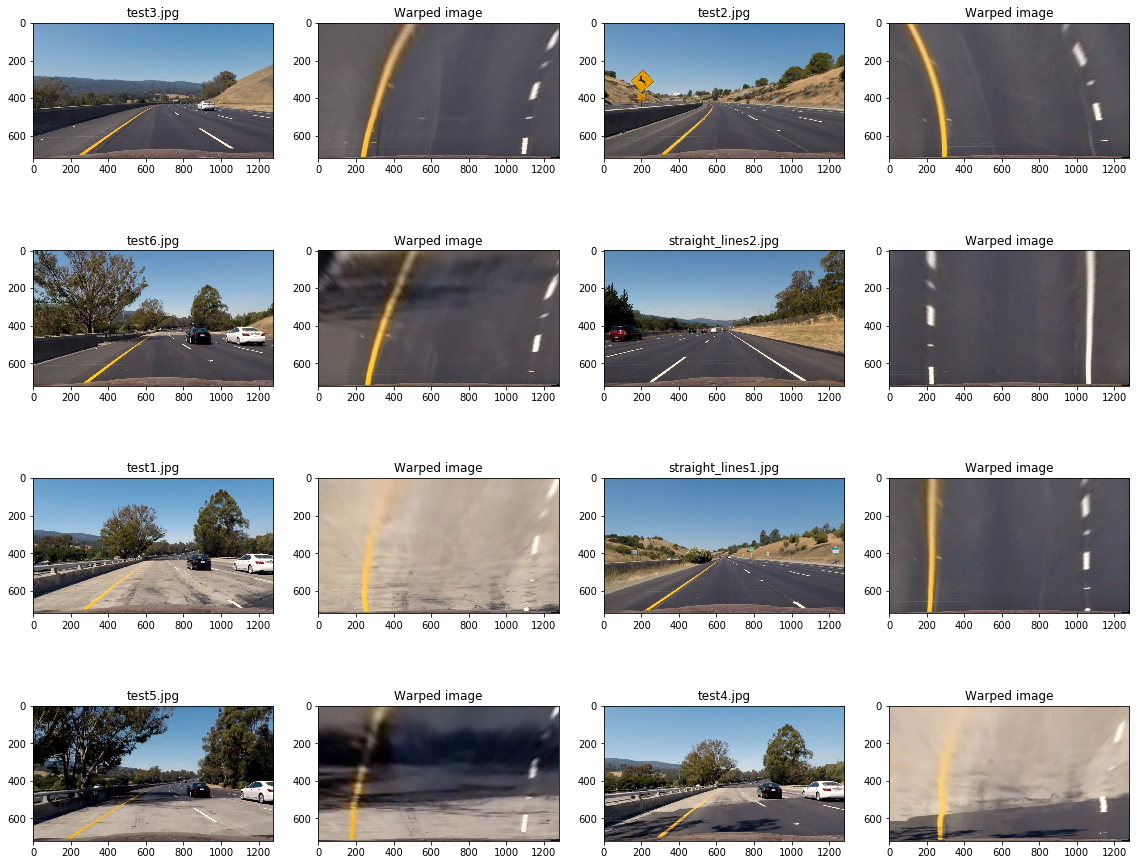

In [6]:
plt.figure(1, figsize=[16,16])

for i, fname in enumerate(os.listdir("test_images/")):
    
    img = cv2.imread("test_images/"+fname)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undistorted = cal_undistort(img, objpoints, imgpoints)
    warped = cv2.warpPerspective(undistorted, M, undistorted.shape[0:2][::-1], flags=cv2.INTER_LINEAR)
    


    plt.subplot(5,4, i*2+1)

    plt.imshow(undistorted)
    plt.title(fname)

    plt.subplot(5,4,i*2+2)
    plt.imshow(warped)
    plt.title("Warped image")

#     plt.show()    

plt.tight_layout()

plt.savefig('output_images/' + 'allImagesWarped.png')

### Binarize image

In [7]:
def preprocess(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    # Threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)

    full_mask = (yellow_mask>0) | (white_mask>0)
    
    subdued_gray = (gray_img / 1.5).astype('uint8')
    boosted_lanes = np.copy(subdued_gray).astype('uint16')
    boosted_lanes[full_mask] = (boosted_lanes[full_mask] * 3)
    boosted_lanes[boosted_lanes>255] = 255
    
    return boosted_lanes.astype('uint8')

In [8]:
def threshIt(img, thresh_min, thresh_max):
    """
    Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    """
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return xbinary
    
def absSobelThresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel gradient on the direction `orient` and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return threshIt(scaled, thresh_min, thresh_max)

def combineGradients(img):
    """
    Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    """
    sobelX = absSobelThresh(img, thresh_min=10, thresh_max=160)
    sobelY = absSobelThresh(img, orient='y', thresh_min=10, thresh_max=160) 
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1))] = 1
    return combined

def binarize(img):
    # Convert RGB cover to HLS color
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     imgSChannel = img[:,:,2]
    imgSChannel = preprocess(img)
    return combineGradients(imgSChannel)
    

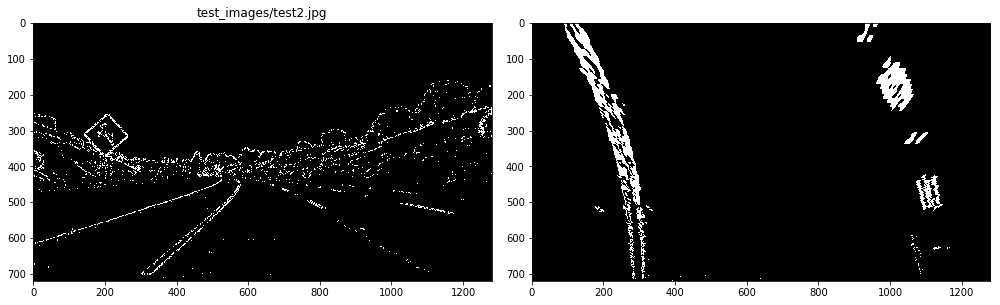

In [9]:
imgName = "test_images/"+'test2.jpg'
img = cv2.imread(imgName)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

undistorted = cal_undistort(img, objpoints, imgpoints)

binary = binarize(undistorted)

warped_binary = cv2.warpPerspective(binary, M, img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)


plt.figure(figsize=[14, 5])
plt.subplot(121)
plt.imshow(binary, cmap='gray')
plt.title(imgName)

plt.subplot(122)
plt.imshow(warped_binary, cmap='gray')
# plt.show()

plt.tight_layout()

plt.savefig('output_images/' + 'binarizedImage.png')

### Using polyfit to find lanes

In [10]:
def findLane(binary_warped, plotImg=False):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 6) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 6) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    left_points=[]
    right_points=[]
    for xl, xr, y in zip(left_fitx, right_fitx, ploty):
        left_points.append([xl, y])
        right_points.append([xr, y])
    left_points=np.array(left_points, np.int32)
    right_points=np.array(right_points, np.int32)    

    cv2.polylines(out_img, [left_points], False, (255,255,0), 6)
    cv2.polylines(out_img, [right_points], False, (255,255,0), 6)    
    
    if plotImg:
        return left_fit, left_lane_inds, left_fitx, right_fit, right_lane_inds, right_fitx, out_img 
    else:
        return left_fit, left_lane_inds, left_fitx, right_fit, right_lane_inds, right_fitx 

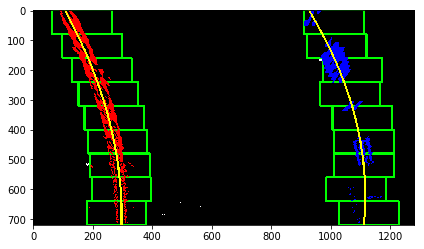

In [11]:
(left_fit, left_lane_inds, left_fitx, 
 right_fit, right_lane_inds, right_fitx, 
 warped_binary_drawLanes) = findLane(warped_binary, plotImg=True)

plt.imshow(warped_binary_drawLanes)

plt.tight_layout()

plt.savefig('output_images/' + 'laneDetect.png')

### Calculate curvature

In [12]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 32/750 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/800 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    left_fit_cr = np.zeros(3)
    
    right_fit_cr = np.zeros(3)
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
#         left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#         right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_fit_cr[0] = l_fit[0]*xm_per_pix/(ym_per_pix)**2
        left_fit_cr[1] = l_fit[1]*xm_per_pix/ym_per_pix
        left_fit_cr[2] = l_fit[2]*xm_per_pix
        
        right_fit_cr[0] = r_fit[0]*xm_per_pix/(ym_per_pix)**2
        right_fit_cr[1] = r_fit[1]*xm_per_pix/ym_per_pix
        right_fit_cr[2] = r_fit[2]*xm_per_pix        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


In [13]:
leftCurvature, rightCurvature, diffFromVehicle = calc_curv_rad_and_center_dist(warped_binary, left_fit, right_fit, 
                                                                               left_lane_inds, right_lane_inds)

if diffFromVehicle > 0:
    message = '{:.2f} m right'.format(diffFromVehicle)
else:
    message = '{:.2f} m left'.format(-diffFromVehicle)
    
print('Left lane curvature: {:.0f} m'.format(leftCurvature))
print('Right lane curvature: {:.0f} m'.format(rightCurvature))
print('Vehicle is {} of center'.format(message))

Left lane curvature: 495 m
Right lane curvature: 404 m
Vehicle is 0.29 m left of center


### Draw image with discovered lanes

In [14]:
def draw_lane(original_img, l_fit, r_fit, Minv, leftCurvature=None, rightCurvature=None, diffFromVehicle=None):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    color_warp = np.zeros_like(original_img).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w, _ = color_warp.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    imgOutput = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    
    if not diffFromVehicle is None:
        leftCurvature = 0 if leftCurvature is None else leftCurvature
        rightCurvature = 0 if rightCurvature is None else rightCurvature
        
        if leftCurvature == 0:
            curvature = rightCurvature
        elif rightCurvature == 0:
            curvature = leftCurvature
        else:
            curvature = 0.5*(leftCurvature + rightCurvature)

        if diffFromVehicle > 0:
            message = '{:.2f} m right'.format(diffFromVehicle)
        else:
            message = '{:.2f} m left'.format(-diffFromVehicle)

        # Draw info
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        cv2.putText(imgOutput, 'Radius of curvature: {:.0f} m'.format(curvature), (50, 50), font, 1.5, fontColor, 2)
        cv2.putText(imgOutput, 'Vehicle is {} of center'.format(message), (50, 120), font, 1.5, fontColor, 2)   

    return imgOutput

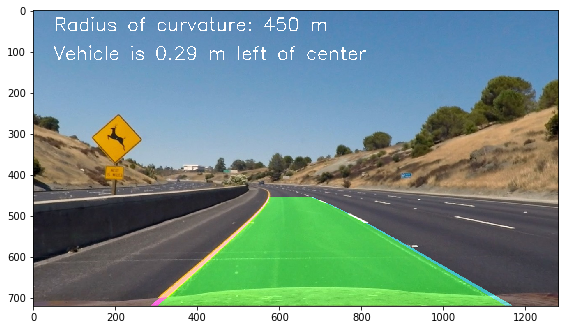

In [15]:
imgDrawLane = draw_lane(undistorted, left_fit, right_fit, Minv, leftCurvature, rightCurvature, diffFromVehicle)


plt.figure(figsize=(8, 6))
plt.imshow(imgDrawLane)
plt.tight_layout()

plt.savefig('output_images/' + 'imageLanePlotted.png')

## Process images with pipe line

In [16]:
def imagePipeLine(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)

    binary = binarize(undistorted)

    warped_binary = cv2.warpPerspective(binary, M, img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

    left_fit, left_lane_inds, left_fitx, right_fit, right_lane_inds, right_fitx, out_img   = findLane(warped_binary, True)

    leftCurvature, rightCurvature, diffFromVehicle = calc_curv_rad_and_center_dist(warped_binary, left_fit, right_fit, left_lane_inds, right_lane_inds)
        
#     print(leftCurvature, rightCurvature)
    
    imgDrawLane = draw_lane(undistorted, left_fit, right_fit, Minv, leftCurvature, rightCurvature, diffFromVehicle)

    return imgDrawLane
    

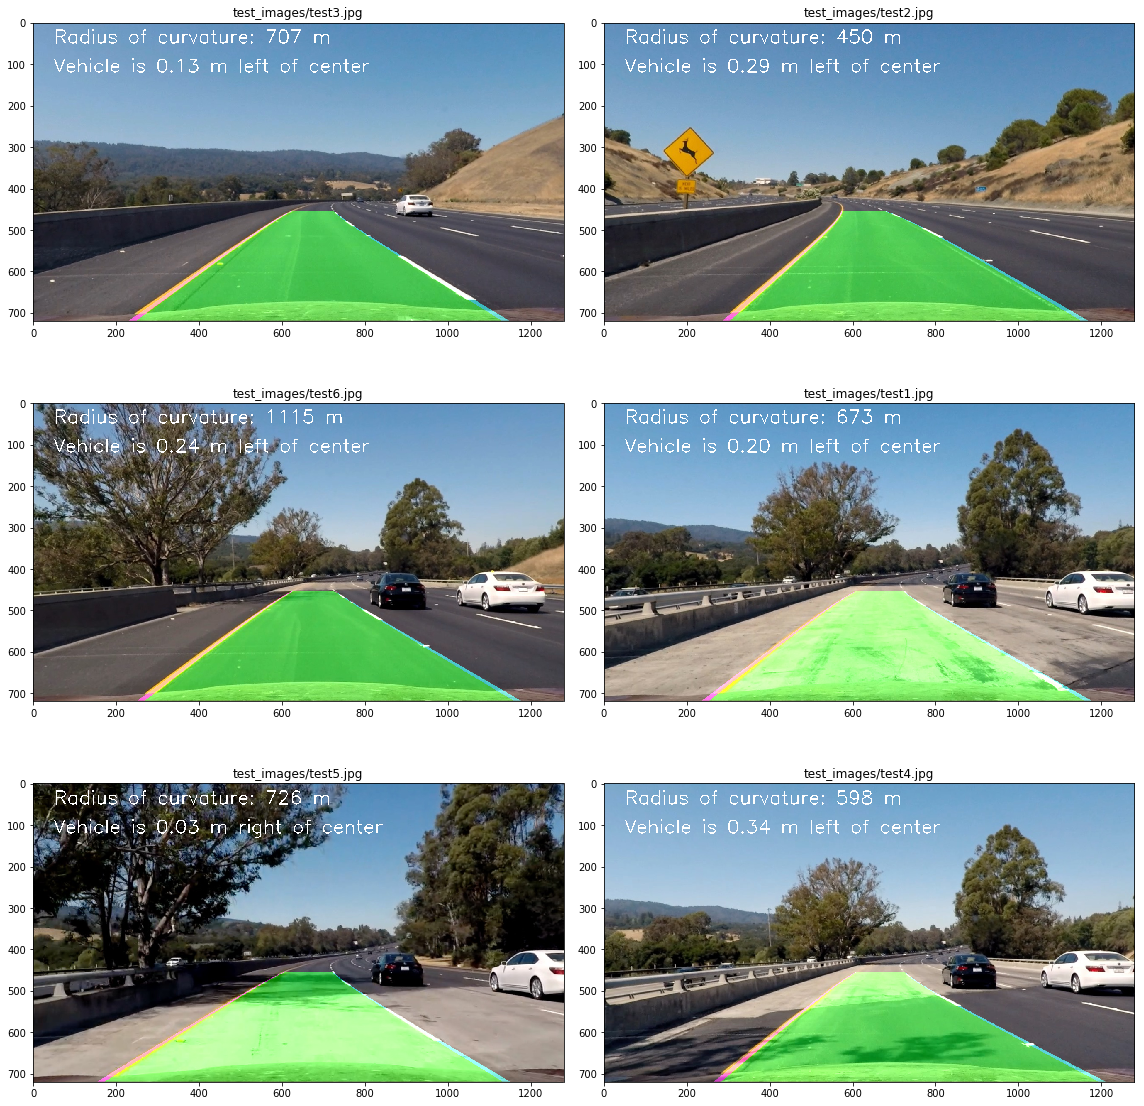

In [17]:
plt.figure(figsize=(16, 16))

for ind, imgName in enumerate(glob.glob("test_images/test*.jpg")):
    img=cv2.imread(imgName)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    imgOutput = imagePipeLine(img)
    plt.subplot(3,2, ind+1)
    plt.imshow(imgOutput)
    plt.title(imgName)
    
plt.tight_layout()

plt.savefig('output_images/' + 'allImageLanePlotted.png')

## Video processing pipeline

In [18]:
from collections import deque

from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self, maxLen=3):
        self.leftCurvatures = deque()
        self.leftFits = deque()
        self.rightCurvatures = deque()
        self.rightFits = deque()
        self.maxLen = maxLen
        self.frameCount = 0

    def insert(self, leftCurv, rightCurv, leftFit, rightFit):
        if len(self.leftCurvatures) == self.maxLen:
            self.leftCurvatures.popleft()
            self.rightCurvatures.popleft()
            self.leftFits.popleft()
            self.rightFits.popleft()
        self.leftCurvatures.append(leftCurv)
        self.rightCurvatures.append(rightCurv)
        self.leftFits.append(leftFit)
        self.rightFits.append(rightFit)
    
    def getCurvatureValues(self):
        return np.mean(self.leftCurvatures), np.mean(self.rightCurvatures)
    
    def getCurveFits(self):
        return np.mean(self.leftFits, axis=0), np.mean(self.rightFits, axis=0)

# class Lane():
#     def __init__(self):
#         self.left_fit = None
#         self.right_fit = None
#         self.leftCurvature = None
#         self.rightCurvature = None
#         self.frameCount = 0


    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    twoLanes = Lane(maxLen=5)
#     leftLane = Lane()
#     rightLane = Lane()
    
    def processImage(img):
        
        undistorted = cal_undistort(img, objpoints, imgpoints)

        binary = binarize(undistorted)

        warped_binary = cv2.warpPerspective(binary, M, img.shape[0:2][::-1], flags=cv2.INTER_LINEAR)

        (left_fit, left_lane_inds, left_fitx, right_fit, 
         right_lane_inds, right_fitx)   = findLane(warped_binary, False)

        leftCurvature, rightCurvature, diffFromVehicle = calc_curv_rad_and_center_dist(warped_binary, 
                                                         left_fit, right_fit, left_lane_inds, right_lane_inds)

        leftCurvature = 0 if leftCurvature is None else leftCurvature
        rightCurvature = 0 if rightCurvature is None else rightCurvature
        
# Method 2
#         if leftCurvature > 10000:
#             left_fit = leftLane.left_fit
#             leftCurvature = leftLane.leftCurvature
#         else:
#             leftLane.left_fit = left_fit
#             leftLane.leftCurvature = leftCurvature
        
#         if rightCurvature > 10000:
#             right_fit = rightLane.right_fit
#             rightCurvature = rightLane.rightCurvature
#         else:
#             rightLane.right_fit = right_fit
#             rightLane.rightCurvature = rightCurvature
        
#         print(leftCurvature, rightCurvature)

#         imgDrawLane = draw_lane(undistorted, left_fit, right_fit, Minv, 
#                                 leftCurvature, rightCurvature, diffFromVehicle)

        frameCount = twoLanes.frameCount
        
        if frameCount <  twoLanes.maxLen or abs(leftCurvature - rightCurvature) < 5000:
            twoLanes.insert(leftCurvature, rightCurvature, left_fit, right_fit)
            
        leftCurvS, rightCurvS = twoLanes.getCurvatureValues()
        left_fitS, right_fitS = twoLanes.getCurveFits()
    
        imgDrawLane = draw_lane(undistorted, left_fitS, right_fitS, Minv, leftCurvS, rightCurvS, diffFromVehicle)
        
        twoLanes.frameCount += 1

        return imgDrawLane

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'video_output/project_video_output.mp4')

[MoviePy] >>>> Building video video_output/project_video_output.mp4
[MoviePy] Writing video video_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [24:34<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video_output.mp4 



In [19]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('video_output/project_video_output.mp4'))

### challenge video

In [ ]:
videoPipeline('challenge_video.mp4', 'video_output/challenge_video_output.mp4')

In [ ]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('video_output/challenge_video_output.mp4'))

### Harder challenge video

In [ ]:
videoPipeline('harder_challenge_video.mp4', 'video_output/harder_challenge_video_output.mp4')

In [ ]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('video_output/harder_challenge_video_output.mp4'))